# Automated Gleason Grade Segmentation: Analysis Notebook

This notebook is designed to load a pre-trained model and pre-computed experiment results to perform a full analysis. **It will not run any new training, hyperparameter optimisation, or evaluation.**

**Workflow:**
1.  **Setup:** Install dependencies and download data from the drive.
2.  **Analyse Data:** Load the pre-processed HDF5 dataset and visualise pathologist agreement and data augmentations.
3.  **Analyse HPO Study:** Load the pre-computed Optuna study and visualise the hyperparameter search results.
4.  **Display Evaluation Results:** Load and display pre-computed quantitative results (metrics, confusion matrix).
5.  **Display Qualitative Analysis:** Load and display pre-computed qualitative results (model predictions on best/worst/most uncertain cases).

### Step 1: Install Dependencies

This cell installs the necessary Python libraries.

In [19]:
try:
  import segmentation_models_pytorch, kornia, optuna, gdown
except ImportError:
  !pip install segmentation_models_pytorch kornia optuna gdown
  import segmentation_models_pytorch, kornia, optuna, gdown

print("Setup complete.")

Setup complete.


In [21]:
import warnings
import sys
from pathlib import Path
import json
import pickle
import pandas as pd
import optuna
from IPython.display import display, Image, Markdown
from pathlib import Path
import numpy as np

src_path = Path('./gleason_src').resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from gleason_src.analysis import (
    plot_optuna_history,
    plot_hyperparameter_overview,
    plot_optuna_slice,
    analyse_pdp,
    analyse_gp,
)
from gleason_src.utils    import download_data
from gleason_src.visualisations import (
    plot_pathologist_agreement_by_class,
    plot_pathologist_reliability,
    plot_evaluation_summary,
    plot_confusion_matrix,
    visualise_augmentations,
    visualise_prediction_extremes,
    visualise_uncertainty_extremes,
    visualise_disagreement_and_predictions
)

warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


The next cell downloads the tissue images, annotations and experiment results from Google Drive.

In [9]:
DATA_DIR     = Path('./gleason_data')

exp_config = {
    'pathologists'    : ['Maps1_T', 'Maps3_T', 'Maps4_T', 'Maps5_T'],
    'target_size'     : (512, 512),
    'gdrive_folder_id': '1v5KFjRYtUb8TbiTK2g4LdV0vqxJi1FPx',
    'seed'            : 42,
    'num_workers'     : 4,
}

download_data(folder_id=exp_config['gdrive_folder_id'], output_dir=DATA_DIR)

gdown.download_folder(id='173jAWHk_miqKVgnwQnsEe4cMYR8EOHBD')

Retrieving folder contents


Retrieving folder 1963ieznDXOPe1Dnd1SymLqkze-fXueQS datasets
Processing file 1YYxcvRclwDwk30FhW7WBqiQdO5uCrgFv gleason_dataset.h5
Retrieving folder 162eD1pq51DsKUu25LzKuNj4ugf3c1kM2 models
Retrieving folder 16b-7V0CCGHsKmfoVVvFJmD9hfiPIWpBZ best-model-from-search
Retrieving folder 16NmSSVprskpw1VDai9UIhLvZquaQWTWo evaluation
Processing file 1-xlKjts1_xSCIX-ZXPgts4RZiNXBcPVh confusion_matrix.png
Processing file 1aNlyHV5sfN2yXfR2LJDebSz7t4ZxcSHr detailed_results.pkl
Processing file 1OnXcS4aj6u9M6GzCfFWZGwzwflCU0MOm summary.json
Processing file 1uQXf-yEMvA03bgOKFNo_QL9clbxOaG5b summary.png
Processing file 1HoioY8iKtzXMzmSAeFDtmG-rIiDFhieK best_model.pth
Processing file 1mjZ-lmtF3Q06i7qqRMx1eEqJ7KsNWuKN config.json
Processing file 10rc6zvZEzZnXVBh23VRL2d_cCMOX1PCY training_curves.png
Retrieving folder 1iKIFRnmZ6aK_Z4mCjT2I03iPgNws3buc visualisations
Processing file 1WyFxhVYdVASGA-TKfJlRIIwEyALFuJ6E pathologist_agreement.png
Processing file 1RtvcuDZ-Xa6y51ofC9yet_64ptBV2J92 pathologist_reli

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1YYxcvRclwDwk30FhW7WBqiQdO5uCrgFv
From (redirected): https://drive.google.com/uc?id=1YYxcvRclwDwk30FhW7WBqiQdO5uCrgFv&confirm=t&uuid=d01c98e6-34f2-44b8-9048-95c72d236013
To: /Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/datasets/gleason_dataset.h5
100%|██████████| 1.66G/1.66G [04:58<00:00, 5.54MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-xlKjts1_xSCIX-ZXPgts4RZiNXBcPVh
To: /Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/evaluation/confusion_matrix.png
100%|██████████| 57.7k/57.7k [00:00<00:00, 979kB/s]
Downloading...
From: https://drive.google.com/uc?id=1aNlyHV5sfN2yXfR2LJDebSz7t4ZxcSHr
To: /Users/biancaciorobea/Downloads/Supporting Materials - 24

['/Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/datasets/gleason_dataset.h5',
 '/Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/evaluation/confusion_matrix.png',
 '/Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/evaluation/detailed_results.pkl',
 '/Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/evaluation/summary.json',
 '/Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/evaluation/summary.png',
 '/Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/best_model.

### Step 2: Define File Paths

In [22]:
OUTPUT_DIR      = Path('./gleason_output')
DATASETS_DIR    = OUTPUT_DIR / 'datasets'
MODELS_DIR      = OUTPUT_DIR / 'models'
H5_PATH         = DATASETS_DIR / 'gleason_dataset.h5'
DB_LOCAL_PATH   = Path("./gleason_study.db")
best_model_name = 'best-model-from-search'
model_dir       = MODELS_DIR / best_model_name
eval_dir        = model_dir / 'evaluation'
summary_path    = eval_dir / 'summary.json'
details_path    = eval_dir / 'detailed_results.h5'

print(f"Output directory: {OUTPUT_DIR.resolve()}")
print(f"Evaluation summary path: {summary_path.resolve()}")

Output directory: /Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output
Evaluation summary path: /Users/biancaciorobea/Downloads/Supporting Materials - 240918756/Supporting-Materials---240918756/gleason_output/models/best-model-from-search/evaluation/summary.json


### Step 3: Analyse Preprocessing and Data Augmentations

This section visualises results from the pre-computed dataset, including inter-pathologist agreement and the data augmentations used during training.

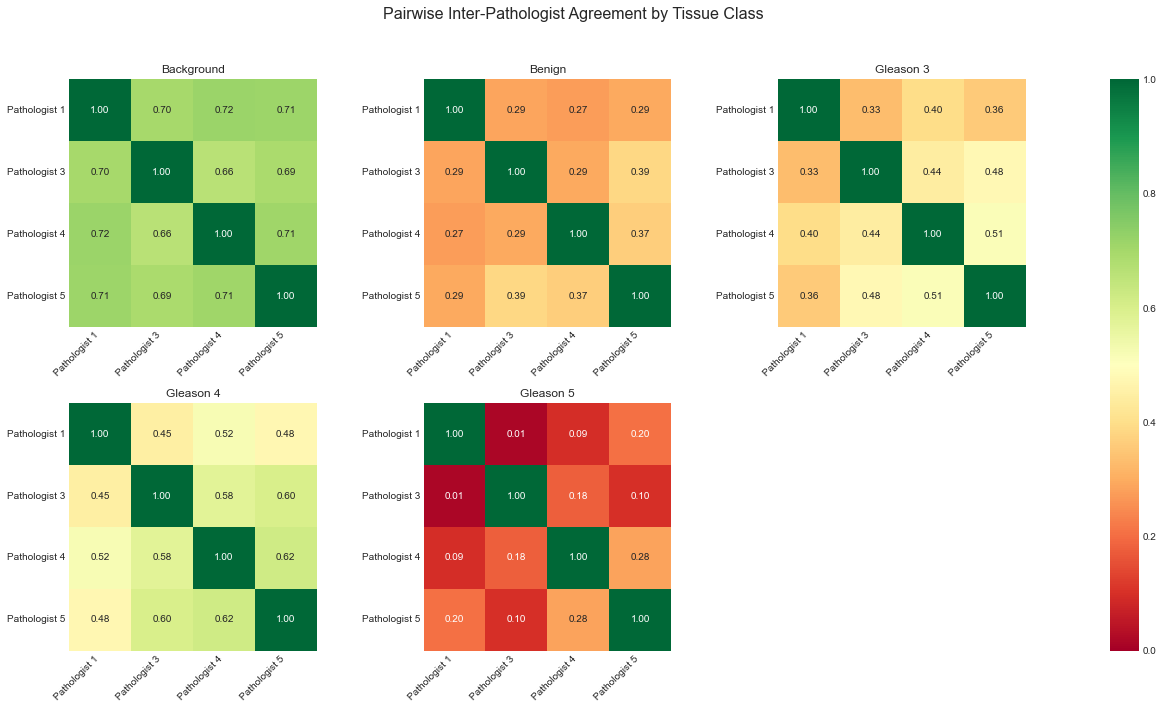

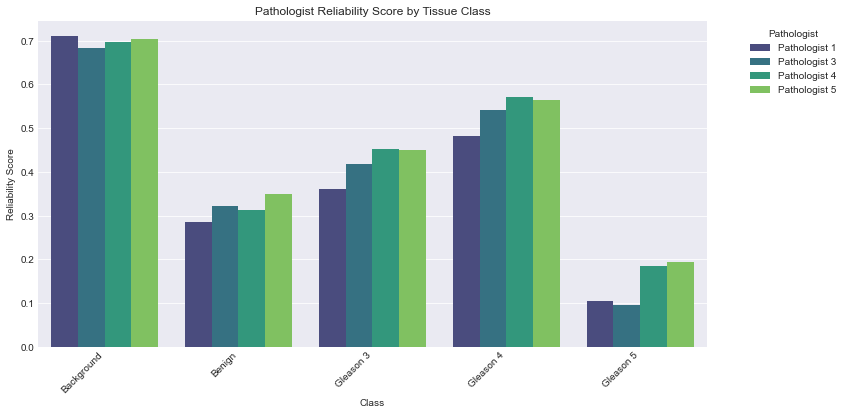

In [23]:
vis_dir       = OUTPUT_DIR / 'visualisations'
metadata_path = OUTPUT_DIR / 'metadata.json'

if metadata_path.exists():
    plot_pathologist_agreement_by_class(metadata_path, display_in_notebook=True)
    plot_pathologist_reliability(metadata_path, display_in_notebook=True)
else:
    print(f"Metadata file not found at {metadata_path}, skipping plots.")

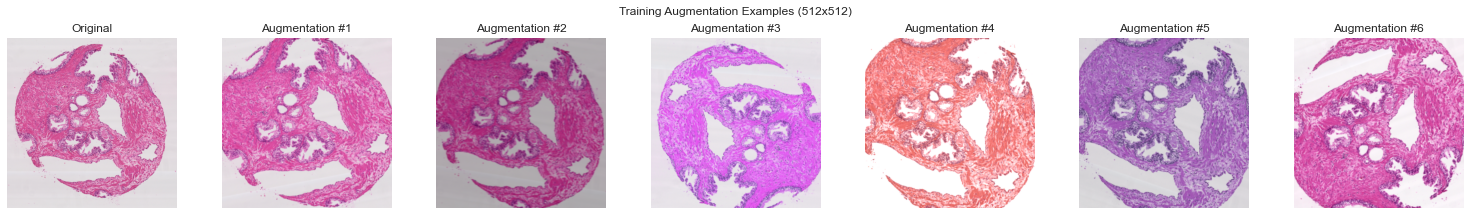

In [24]:
if H5_PATH.exists():
    visualise_augmentations(dataset_path=H5_PATH, num_examples=7, img_size=512, display_in_notebook=True)
else:
    print(f"HDF5 dataset not found at {H5_PATH}, skipping augmentation visualisation.")

### Step 4: Load and Analyse Hyperparameter Optimisation Study

We load the pre-computed results from the downloaded `gleason_study.db` file and visualise the outcomes.

In [25]:
local_db_uri = f"sqlite:///{DB_LOCAL_PATH}"

if DB_LOCAL_PATH.exists():
    try:
        study = optuna.load_study(
            study_name="gleason-search",
            storage=local_db_uri
        )
        print(f"Successfully loaded study '{study.study_name}' with {len(study.trials)} trials.")
        print(f"Best trial score: {study.best_value:.4f}")
    except Exception as e:
        print(f"Could not load Optuna study: {e}")
        study = None
else:
    print(f"Optuna database not found at {DB_LOCAL_PATH}. Skipping HPO analysis.")
    study = None

Successfully loaded study 'gleason-search' with 153 trials.
Best trial score: 1.0642


#### HPO Analysis Visualisations

Standard HPO Visualisations


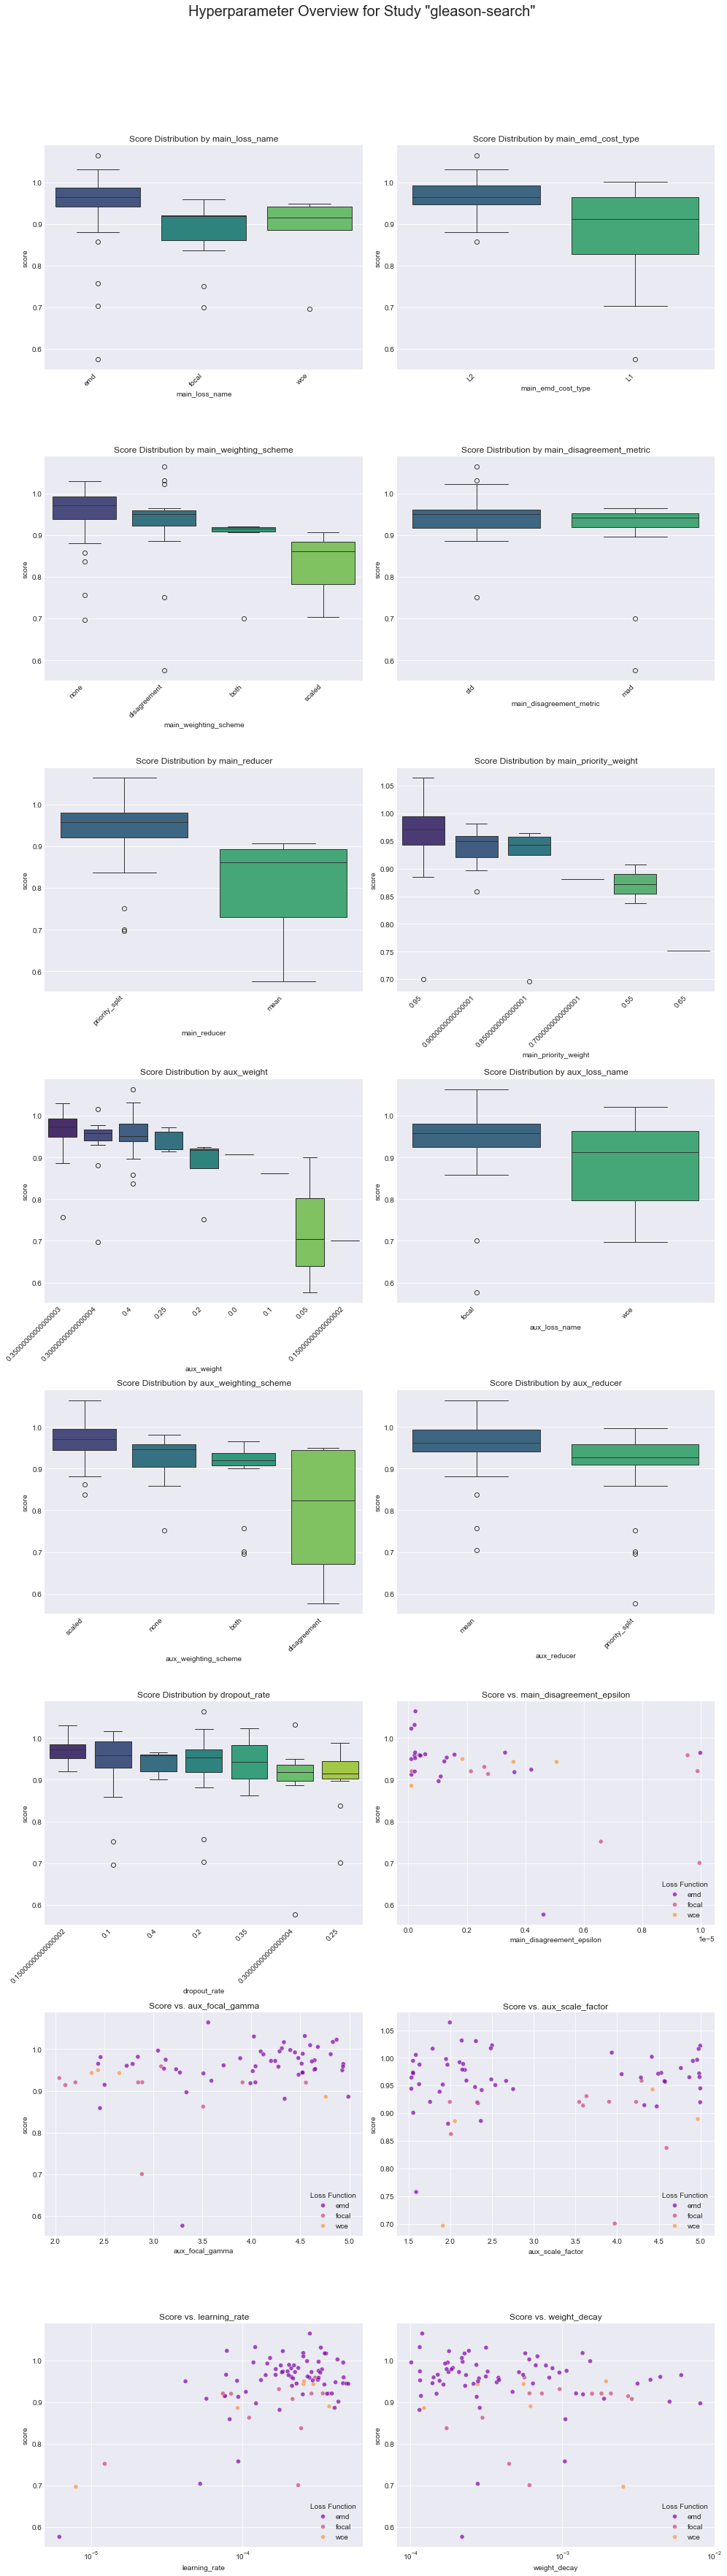


Exported all 153 trials to gleason_output/optuna_exports/gleason_hpo_report.xlsx

Sample of Optuna Trial Results


,number,value,state,params_learning_rate,params_dropout_rate,params_main_loss_name
0,0,0.576487,COMPLETE,0.000006,0.3,emd
1,1,0.751651,COMPLETE,0.000012,0.1,focal
2,2,0.907071,COMPLETE,0.000214,0.3,focal
3,3,0.757382,COMPLETE,0.000094,0.2,emd
4,4,0.703660,COMPLETE,0.000053,0.2,emd


In [26]:
if study and study.trials:
    print("Standard HPO Visualisations")
    plot_optuna_history(study, display_in_notebook=True)
    plot_hyperparameter_overview(study, display_in_notebook=True)
    plot_optuna_slice(study, display_in_notebook=True)
    
    study_df = study.trials_dataframe()
    export_dir = OUTPUT_DIR / 'optuna_exports'
    export_dir.mkdir(parents=True, exist_ok=True)
    excel_path = export_dir / f"gleason_hpo_report.xlsx"
    study_df.to_excel(excel_path, index=False)
    print(f"\nExported all {len(study_df)} trials to {excel_path}")

    print("\nSample of Optuna Trial Results")
    display_cols = ['number', 'value', 'state', 'params_learning_rate', 'params_dropout_rate', 'params_main_loss_name']
    valid_cols = [c for c in display_cols if c in study_df.columns]
    display(study_df[valid_cols].head())

else:
    print("Optuna study not loaded or has no trials. Skipping HPO analysis.")



Advanced HPO Analysis (found 86 completed trials) 
Running Surrogate Model (PDP) analysis
LGBM not found, skipping Surrogate Model/PDP analysis. Install with: pip install lightgbm

Running Gaussian Process (GP) analysis


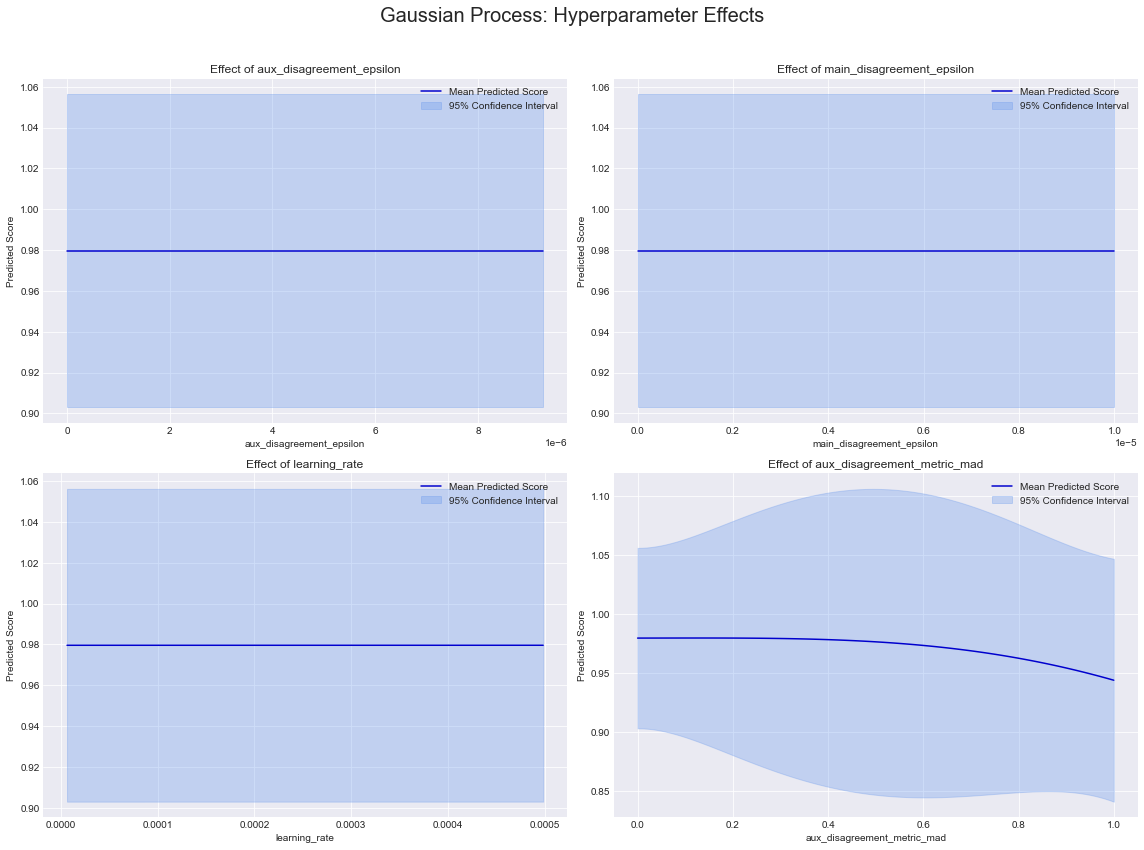

In [16]:
if study and study.trials:
    analysis_dir = OUTPUT_DIR / 'visualisations' / 'advanced_analysis'
    analysis_dir.mkdir(parents=True, exist_ok=True)

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    print(f"\nAdvanced HPO Analysis (found {len(completed_trials)} completed trials) ")

    if len(completed_trials) >= 10:
        try:
            print("Running Surrogate Model (PDP) analysis")
            analyse_pdp(study, save_dir=analysis_dir, display_in_notebook=True)
        except Exception as e:
            print(f"PDP analysis failed: {e}")

        try:
            print("\nRunning Gaussian Process (GP) analysis")
            analyse_gp(study, save_dir=analysis_dir, display_in_notebook=True)
        except Exception as e:
            print(f"GP analysis failed: {e}")
    else:
        print(f"Insufficient data for advanced analysis. Need at least 10 trials, got {len(completed_trials)}.")
else:
    print("Skipping advanced analysis.")

### Step 5: Display Quantitative Evaluation Results

This section loads the pre-computed evaluation summary and prints the key performance metrics, then visualises the results.

Evaluation Metrics for 'best-model-from-search'
  pixel_accuracy_mean                     : 0.7612
  pixel_accuracy_std                      : 0.3238
  dice_score_mean                         : 0.4908
  dice_score_std                          : 0.4559
  iou_score_mean                          : 0.4598
  iou_score_std                           : 0.4488
  gleason_dice_score_mean                 : 0.4908
  gleason_dice_score_std                  : 0.1684
  williams_index_mean                     : 1.0096
  williams_index_std                      : 0.3522
  grade_aware_williams_index_mean         : 0.8818
  grade_aware_williams_index_std          : 0.3848
  kappa_f1_combo_mean                     : 0.4972
  kappa_f1_combo_std                      : 0.2339
  model_pathologist_gleason_dice:
  inter_pathologist_gleason_dice:

Generating Visualisations


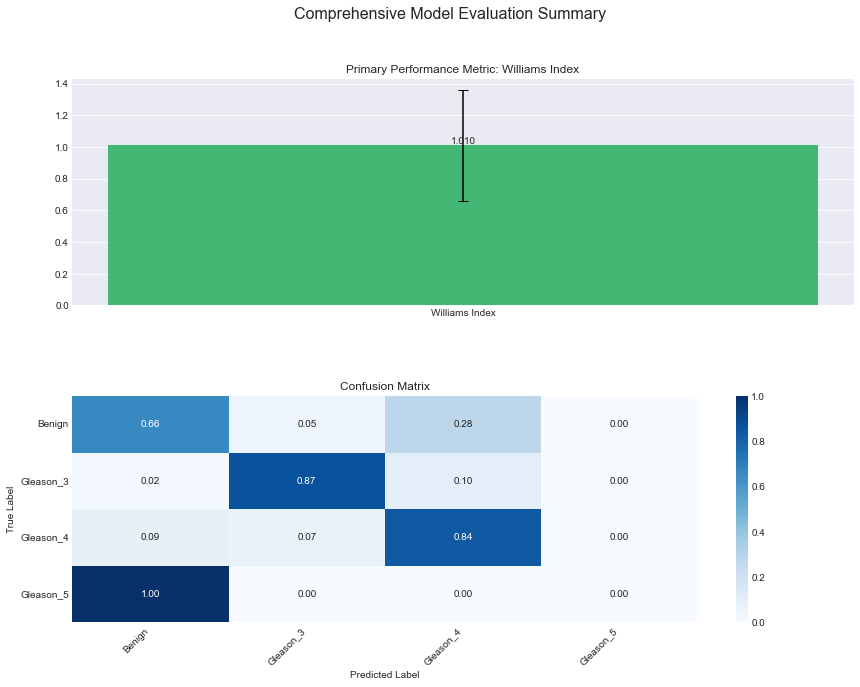

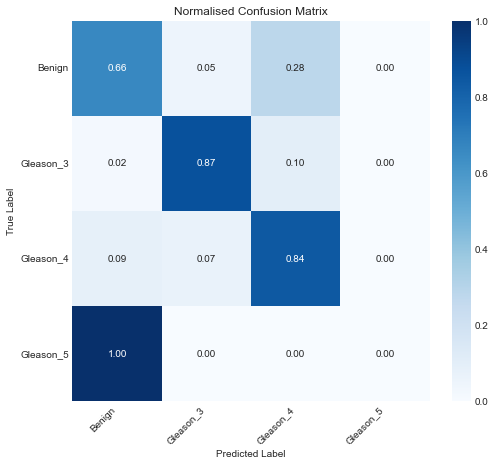

In [17]:
if summary_path.exists():
    print(f"Evaluation Metrics for '{best_model_name}'")
    with open(summary_path, 'r') as f:
        summary_data = json.load(f)

    for key, value in summary_data.items():
        if key in ['confusion_matrix', 'class_names'] or 'per_class' in key:
            continue 
        if isinstance(value, float):
            print(f"  {key:<40}: {value:.4f}")
        elif isinstance(value, dict):
            print(f"  {key}:")
            for sub_key, sub_value in value.items():
                print(f"    - {sub_key:<30}: {sub_value:.4f}")
        else:
            print(f"  {key:<40}: {value}")

    print("\nGenerating Visualisations")
    plot_evaluation_summary(summary_path, primary_metric='williams_index', display_in_notebook=True)
    plot_confusion_matrix(summary_path, display_in_notebook=True)
else:
    print(f"Evaluation summary not found at {summary_path}. Cannot display results.")

### Step 6: Display Qualitative Analysis

Finally, we visualise the model's pre-computed predictions on specific examples to gain qualitative insights.

- **Prediction Extremes:** Shows the best and worst performing images according to different metrics.
- **High Uncertainty Samples:** Shows the model's most uncertain predictions.
- **Disagreement:** Shows how the model performs on cases where the human experts disagreed the most.

In [18]:
eval_dir = MODELS_DIR / best_model_name / 'evaluation'
disagreement_dir = eval_dir / 'disagreement_visuals'

expected_files = [
    eval_dir / 'extremes_gleason_dice_best.png',
    eval_dir / 'extremes_gleason_dice_worst.png',
    eval_dir / 'extremes_williams_index_best.png',
    eval_dir / 'extremes_williams_index_worst.png',
    eval_dir / 'extremes_uncertainty_most_certain.png',
    eval_dir / 'extremes_uncertainty_most_uncertain.png'
]

display(Markdown("## Qualitative Analysis Visualisations"))

for file_path in expected_files:
    if file_path.exists():
        title = file_path.stem.replace('_', ' ').title()
        display(Markdown(f"### {title}"))
        display(Image(filename=str(file_path), width=800))
    else:
        print(f"File not found: {file_path}")

if disagreement_dir.exists():
    disagreement_files = sorted([f for f in disagreement_dir.iterdir() if f.suffix.lower() == '.png'])
    if disagreement_files:
        display(Markdown("### High-Disagreement Sample Analysis"))
        for file_path in disagreement_files:
            display(Image(filename=str(file_path), width=1000))
    else:
        print(f"No disagreement images found in: {disagreement_dir}")
else:
    print(f"Disagreement directory not found: {disagreement_dir}")

## Qualitative Analysis Visualisations

File not found: gleason_output/models/best-model-from-search/evaluation/extremes_gleason_dice_best.png
File not found: gleason_output/models/best-model-from-search/evaluation/extremes_gleason_dice_worst.png
File not found: gleason_output/models/best-model-from-search/evaluation/extremes_williams_index_best.png
File not found: gleason_output/models/best-model-from-search/evaluation/extremes_williams_index_worst.png
File not found: gleason_output/models/best-model-from-search/evaluation/extremes_uncertainty_most_certain.png
File not found: gleason_output/models/best-model-from-search/evaluation/extremes_uncertainty_most_uncertain.png
Disagreement directory not found: gleason_output/models/best-model-from-search/evaluation/disagreement_visuals
